In [248]:
%matplotlib notebook

import itertools
import random

import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import tqdm

# Summary of Riddler Express

On snowy afternoons, you like to play a solitaire “game” with a standard, randomly shuffled deck of 52 cards. You start dealing cards face up, one at a time, into a pile. As you deal each card, you also speak aloud, in order, the 13 card faces in a standard deck: ace, two, three, etc. (When you get to king, you start over at ace.) You keep doing this until the rank of the card you deal matches the rank you speak aloud, in which case you lose. You win if you reach the end of the deck without any matches.

What is the probability that you win?

In [20]:
deck = list(range(52))
WIN = True
LOSE = False

def game(deck):
    random.shuffle(deck)
    for (i, elem) in enumerate(deck):
        if (i % 13) == (elem % 13):
            return LOSE
    return WIN

In [30]:
numSimuls = int(1e6)
x = [game(deck) for i in tqdm.trange(numSimuls)]
sum(x) / len(x)

100%|██████████| 1000000/1000000 [00:49<00:00, 20312.35it/s]


0.016195

## interactive plot of one large simulation

<IPython.core.display.Javascript object>


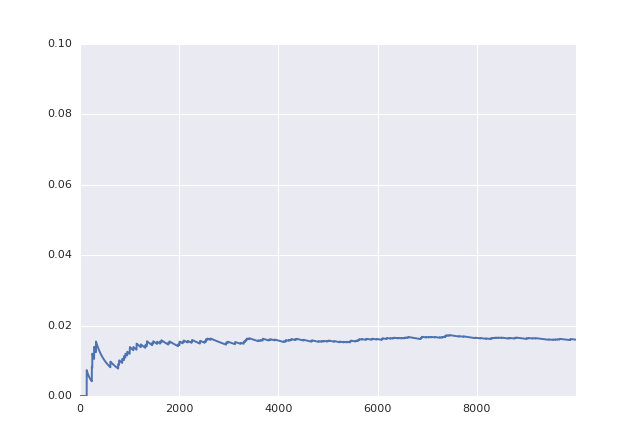

In [140]:
numSimuls = int(1e4)
x = []
probs = []
f, s = plt.subplots()
del plot
p = 0
for i in range(numSimuls):
    xnow = game(deck)
    x.append(xnow)
    p = (i * p + xnow) / (i + 1)
    probs.append(p)
    
    try:
        plotData = plot.get_data()
        newx = sp.append(plotData[0], i)
        newy = sp.append(plotData[1], p)
        plot.set_data((newx, newy))
        s.set_xlim(-.5, i + .5)
        f.canvas.draw()
    except Exception as e:
        plot = s.plot([i], [p], marker=None, linestyle='-')[0]
        s.set_ylim(0, 0.1)

## many large simulations, results averaged

In [151]:
numSimuls = int(1e3)
simulSize = int(1e5)

results = []
for i in tqdm.tnrange(numSimuls, desc='simulation group'):
    wins = 0
    for j in tqdm.tnrange(simulSize, desc='simulation', leave=False):
        wins += game(deck)
    results.append(wins / simulSize)
    
avResult = sp.average(results)
stdResult = sp.std(results)

print(avResult)
print(stdResult)


0.016056
0.00120377074229


# Summary of Riddler Classic

Baby poker is played by two players, each holding a single die in a cup. The game starts with each player anteing \$1. Then both shake their die, roll it, and look at their own die only. Player A can then either “call,” in which case both dice are shown and the player with the higher number wins the \$2 on the table, or Player A can “raise,” betting one more dollar. If A raises, then B has the option to either “call” by matching A’s second dollar, after which the higher number wins the \$4 on the table, or B can “fold,” in which case A wins but B is out only his original \$1. No other plays are made, and if the dice match, a called pot is split equally.

What is the optimal strategy for each player? Under those strategies, how much is a game of baby poker worth to Player A? In other words, how much should A pay B beforehand to make it a fair game?

## solving with a simulation

In [345]:
CALL = False
RAISE = True
FOLD = True

random.seed(1337)

class Gambler(object):
    def roll(self):
        return random.randint(0, 5)
    
    def bet(self, die):
        raise NotImplementedError()
        
        
class A(Gambler):
    def __init__(self, strategy):
        """a strategy is a 5-element sequence of CALL or RAISE, indicating what 
        person A will do each time they see a die with that index's value. We
        assume by fiat that a roll of 6 will always result in a RAISE
        
        for example:
            
            [CALL, CALL, RAISE, RAISE, RAISE]
            
        will call if a 0 or 1 is rolled, and will raise otherwise (assuming the
        sides of our die are 0 - 5 and not 1 - 6 for convenience)
        
        """
        self.strategy = strategy + (RAISE,)
        self.money = 0
    
    def bet(self, die):
        return self.strategy[die]
    
    @staticmethod
    def strategies():
        """a generator of all possible strategies for a type-A gambler"""
        return itertools.product([CALL, RAISE], repeat=5)
    
    
class B(Gambler):
    def __init__(self, strategy):
        """B only makes decisions when A has raise, and their only decision is
        CALL or FOLD. Therefore their strategies are effectively the same as
        those of A. I could move this into the Gambler class, but I'll leave it
        here just to be explicit. as with A, we assume that a die roll of 6 will 
        always result in a CALL 
            
        """
        self.strategy = strategy + (CALL,)
        self.money = 0
        
    def bet(self, die):
        return self.strategy[die]
    
    @staticmethod
    def strategies():
        """a generator of all possible strategies for a type-A gambler"""
        return itertools.product([CALL, FOLD], repeat=5)

In [346]:
a = A((CALL,) * 5)
b = B((CALL,) * 5)

In [347]:
def play_one_game(a, b):
    adie = a.roll()
    abet = a.bet(adie)
    
    bdie = b.roll()
    bbet = b.bet(bdie)
    
    if abet == RAISE and bbet == FOLD:
        # dice don't matter
        a.money += 1
        b.money -= 1
    else:
        # RAISE/FOLD is out, so we either CALL/NULL (1) or RAISE/CALL (2)
        pot = 1 if abet == CALL else 2

        if adie > bdie:
            a.money += pot
            b.money -= pot
        elif adie < bdie:
            a.money -= pot
            b.money += pot

def play_n_games(a, b, n):
    for i in range(n):
        play_one_game(a, b)

In [295]:
play_one_game(a, b)
print(a.money)
print(b.money)

5
-5


In [312]:
def strat_to_key(strat, stratType='A'):
    if stratType == 'A':
        return ''.join([('C' if x == CALL else 'R') for x in strat])
    elif stratType == 'B':
        return ''.join([('C' if x == CALL else 'F') for x in strat])

In [339]:
nSimulations = 100
gamesPerSimulation = 1000
numStratA = len(list(A.strategies()))
numStratB = len(list(B.strategies()))

stratResults = []
for astrat in tqdm.tqdm_notebook(A.strategies(), desc='A strategies', total=numStratA):
    a = A(astrat)
    akey = strat_to_key(astrat, stratType='A')
    for bstrat in tqdm.tqdm_notebook(B.strategies(), desc='B strategies', total=numStratB, leave=False):
        b = B(bstrat)
        bkey = strat_to_key(bstrat, stratType='B')
        for i in range(nSimulations):
            # reset to start simulation
            a.money = 0
            b.money = 0
            play_n_games(a, b, gamesPerSimulation)
            gameresults.append(a.money)
            stratResults.append({
                'akey': akey,
                'bkey': bkey,
                'game': i,
                'a_money': a.money
            })

stratResults = pd.DataFrame(stratResults)

In [340]:
stratResults.head()

,a_money,akey,bkey,game
0,86,CCCCC,CCCCC,0
1,154,CCCCC,CCCCC,1
2,160,CCCCC,CCCCC,2
3,196,CCCCC,CCCCC,3
4,182,CCCCC,CCCCC,4


### biggest mismatch

In [341]:
abmoney = stratResults.groupby(['akey', 'bkey']).a_money.agg([sp.sum, sp.mean, sp.std])
abmoney = abmoney.sort_values(by=['mean', 'std'], ascending=[False, True])
abmoney.head()

sum    mean        std
akey  bkey                           
RRRRR CFFFF  67051  670.51  37.641717
      CCFFF  66636  666.36  40.132739
RRRRC CFFFF  63989  639.89  29.260203
      CCFFF  61647  616.47  38.117695
RRRCR CFFFF  58205  582.05  39.444213

### best A strategy, regardless

In [342]:
amoney = stratResults.groupby('akey').a_money.agg([sp.sum, sp.mean, sp.std])
amoney = amoney.sort_values(by=['mean', 'std'], ascending=[False, True])
amoney.head()

,sum,mean,std
akey,,,
RRRRR,889586,277.995625,221.460519
RRRRC,760164,237.551250,218.314645
CRRRR,756866,236.520625,171.722022
RCRRR,755841,236.200312,157.001776
RRRCR,755459,236.080938,183.135565


### best B strategy, regardless

In [343]:
bmoney = stratResults.groupby('bkey').a_money.agg([sp.sum, sp.mean, sp.std])
bmoney = bmoney.sort_values(by=['mean', 'std'])
bmoney.head()

,sum,mean,std
bkey,,,
FFCCC,-43510,-13.596875,77.510576
FCCCC,6111,1.909687,98.834681
FFFCC,87116,27.223750,62.804354
FCFCC,134300,41.968750,52.208364
CFCCC,180826,56.508125,71.571656


### best B strategy given optimal A (aka fair handicap)

In [344]:
aOptbmoney = stratResults[stratResults.akey == amoney.index[0]].groupby('bkey').a_money.agg([sp.sum, sp.mean, sp.std])
aOptbmoney = aOptbmoney.sort_values(by=['mean', 'std'])
aOptbmoney.head()

,sum,mean,std
bkey,,,
FCCCC,-11984,-119.84,51.671597
FFCCC,-10989,-109.89,48.465732
CFCCC,-588,-5.88,55.203074
FCFCC,-525,-5.25,55.156595
FFFCC,-6,-0.06,44.860462


## solving analytically

the payout functions for $A$ are

$$
f
$$
